# 🌀 Circular Cross-Entropy Loss – Verification Notebook

This notebook implements **circular label smoothing** and a **circular cross-entropy** loss for orientation classification (90 bins, wrap-around),
and runs several diagnostic tests (shape, wrap-around symmetry, close-vs-far, gradient check) plus a visualization of the smoothed targets.

In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
torch.manual_seed(0)
print('torch:', torch.__version__)


torch: 2.5.1


## 1) Functions: circular_smooth_labels & circular_cross_entropy

In [3]:
def circular_smooth_labels(true_idx, num_classes=90, sigma=1.5):
    """
    Create wrapped Gaussian soft labels for circular classes.

    Args:
        true_idx: LongTensor of shape (B, H, W) with values in [0, num_classes-1].
        num_classes: int, number of discrete angular bins (e.g. 90).
        sigma: float, smoothing kernel width in *bins*.

    Returns:
        Tensor of shape (B, C, H, W) with probabilities summing to 1 along C.
    """
    if not torch.is_tensor(true_idx):
        raise TypeError('true_idx must be a torch tensor')
    if true_idx.dim() != 3:
        raise ValueError('true_idx must have shape (B,H,W)')

    device = true_idx.device
    B, H, W = true_idx.shape
    classes = torch.arange(num_classes, device=device).view(1, num_classes, 1, 1)  # (1,C,1,1)
    true_idx_exp = true_idx.unsqueeze(1)  # (B,1,H,W)

    diff = torch.abs(classes - true_idx_exp)  # broadcast to (B,C,H,W)
    diff = torch.minimum(diff, (num_classes - diff))  # wrap-around distance

    weights = torch.exp(-0.5 * (diff.float() / float(sigma)) ** 2)
    weights = weights / weights.sum(dim=1, keepdim=True)
    return weights


def circular_cross_entropy(pred_logits, true_idx, num_classes=90, sigma=1.5, reduction='mean'):
    """
    pred_logits: Tensor (B, C, H, W) raw logits
    true_idx: LongTensor (B, H, W) class indices
    Returns scalar loss (or per-cell if reduction=None)
    """
    if pred_logits.dim() != 4:
        raise ValueError('pred_logits must have shape (B,C,H,W)')
    if true_idx.dim() != 3:
        raise ValueError('true_idx must have shape (B,H,W)')
    if pred_logits.size(1) != num_classes:
        raise ValueError('pred_logits.size(1) must equal num_classes')

    soft_targets = circular_smooth_labels(true_idx, num_classes=num_classes, sigma=sigma)
    log_probs = F.log_softmax(pred_logits, dim=1)
    per_cell = -(soft_targets * log_probs).sum(dim=1)  # (B,H,W)

    if reduction == 'mean':
        return per_cell.mean()
    elif reduction == 'sum':
        return per_cell.sum()
    elif reduction is None:
        return per_cell
    else:
        raise ValueError('reduction must be one of {"mean","sum",None}')


## 2) Basic sanity test (shapes / runtime)

In [15]:
pred = torch.randn(2, 90, 4, 4)
true_idx = torch.randint(0, 90, (2, 4, 4))
loss = circular_cross_entropy(pred, true_idx)
print('Basic test loss (random):', loss.item())


Basic test loss (random): 4.925586700439453


In [18]:
pred.shape, true_idx.shape

(torch.Size([2, 90, 4, 4]), torch.Size([2, 4, 4]))

## 3) Wrap-around symmetry test

Check that class 0 and class 89 behave symmetrically for uniform logits.

In [20]:
logits = torch.zeros(1, 90, 1, 1)
true_idx_0 = torch.tensor([[[0]]])
true_idx_89 = torch.tensor([[[89]]])

loss_0 = circular_cross_entropy(logits, true_idx_0)
loss_89 = circular_cross_entropy(logits, true_idx_89)

print('Loss at class 0:', loss_0.item())
print('Loss at class 89:', loss_89.item())
print('Absolute difference:', abs(loss_0.item() - loss_89.item()))


Loss at class 0: 4.499809265136719
Loss at class 89: 4.499809741973877
Absolute difference: 4.76837158203125e-07


## 4) Close vs Far test

Predictions that are close (1 bin away) should have much lower loss than predictions ~45 bins away (~90°).

In [ ]:
# ✅ Ground truth class index: class 0 (e.g. -90° orientation)
# Shape: (batch=1, height=1, width=1)
true_idx = torch.tensor([[[0]]])

# -----------------------------
# Case 1: Model predicts the correct class with high confidence
# -----------------------------

# Create a logits tensor filled with -10.0 (very low confidence)
# Shape: (1 batch, 90 classes, 1 height, 1 width)
pred_correct = torch.full((1, 90, 1, 1), -10.0)

# Set the logit of the correct class (index 0) to a high value (10.0)
# This simulates the model being very confident about the correct class
pred_correct[:, 0] = 10.0

# Compute the circular cross-entropy loss for this prediction
# Expected: very low loss (near 0), since the prediction is correct
loss_correct = circular_cross_entropy(pred_correct, true_idx)

# -----------------------------
# Case 2: Model predicts a class close to the correct one
# -----------------------------

# Create logits again with very low values (-10.0)
pred_close = torch.full((1, 90, 1, 1), -10.0)

# Now the model predicts class 1 with high confidence (close to -88)
# This simulates a small angular error (~2° difference)
pred_close[:, 1] = 10.0

# Compute the circular loss
# Expected: slightly higher than loss_correct, but still low
loss_close = circular_cross_entropy(pred_close, true_idx)

# -----------------------------
# Case 3: Model predicts a far-away class (about 90° away)
# -----------------------------

# Again, create a tensor with all logits very low
pred_far = torch.full((1, 90, 1, 1), -10.0)

# Set a far-away class (index 45) to high confidence
# This simulates a ~90° error — the worst possible in this setup
pred_far[:, 45] = 10.0

# Compute the circular loss
# Expected: much higher than both loss_correct and loss_close
loss_far = circular_cross_entropy(pred_far, true_idx)

# -----------------------------
# Print the results for comparison
# -----------------------------

print(f'Loss (correct): {loss_correct.item():.6f}')  # lowest loss
print(f'Loss (close):   {loss_close.item():.6f}')    # higher but still low
print(f'Loss (far):     {loss_far.item():.6f}')      # highest loss

Loss (correct): 14.680767
Loss (close):   15.740690
Loss (far):     19.999996


## 5) Compare with standard CrossEntropyLoss

On arbitrary logits the numbers may be similar; on wrap cases standard CE will not respect circular neighbors.

In [7]:
pred_rand = torch.randn(1, 90, 3, 3)
true_rand = torch.randint(0, 90, (1, 3, 3))
ce_loss_fn = torch.nn.CrossEntropyLoss()
loss_standard = ce_loss_fn(pred_rand, true_rand)
loss_circular = circular_cross_entropy(pred_rand, true_rand)
print('Standard CE loss:', loss_standard.item())
print('Circular CE loss:', loss_circular.item())


Standard CE loss: 5.183502674102783
Circular CE loss: 5.126371383666992


## 6) Gradient sanity check

Make sure the loss is differentiable and returns finite gradients.

In [8]:
pred_g = torch.randn(1, 90, 4, 4, requires_grad=True)
true_g = torch.randint(0, 90, (1, 4, 4))
loss_g = circular_cross_entropy(pred_g, true_g)
loss_g.backward()
print('Loss:', loss_g.item())
print('Grad mean:', pred_g.grad.mean().item())
print('Grad std:', pred_g.grad.std().item())


Loss: 4.983753204345703
Grad mean: 2.0696057714819638e-11
Grad std: 0.002905492438003421


## 7) Visualize smoothed label distribution

Plot the class probabilities for a ground-truth class at index 0 to check wrap-around.

Sum(probabilities) = 0.9999999


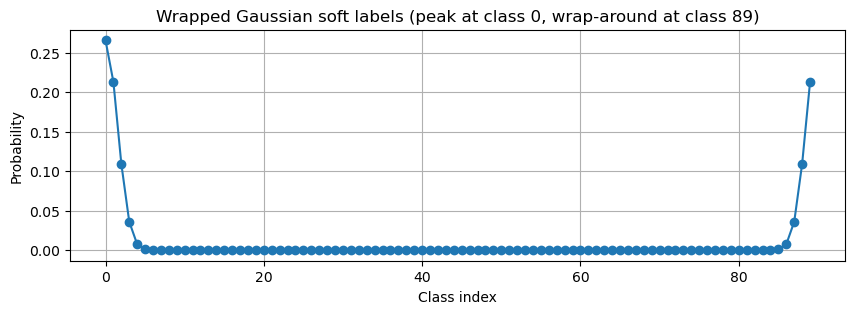

In [9]:
true_vis = torch.tensor([[[0]]])
soft = circular_smooth_labels(true_vis, num_classes=90, sigma=1.5)[0, :, 0, 0].cpu().numpy()
print('Sum(probabilities) =', soft.sum())
plt.figure(figsize=(10,3))
plt.plot(soft, marker='o')
plt.title('Wrapped Gaussian soft labels (peak at class 0, wrap-around at class 89)')
plt.xlabel('Class index')
plt.ylabel('Probability')
plt.grid(True)
plt.show()
